In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!pip install torch-geometric
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch
import torch.nn.functional as F
from statsmodels.tsa.stattools import grangercausalitytests

In [4]:
btc_df = pd.read_csv("/content/drive/MyDrive/CryptoDataset/Main dataset/Bitcoin Historical Data.csv")
eth_df = pd.read_csv("/content/drive/MyDrive/CryptoDataset/Main dataset/Ethereum Historical Data.csv")
teth_df = pd.read_csv("/content/drive/MyDrive/CryptoDataset/Main dataset/Tether USDt Historical Data.csv")
sol_df = pd.read_csv("/content/drive/MyDrive/CryptoDataset/Main dataset/Solana Historical Data.csv")
fsi_df = pd.read_csv("/content/drive/MyDrive/CryptoDataset/Main dataset/fsi.csv")

In [5]:
# Using the minimum number of rows
min_rows = min(btc_df.shape[0], eth_df.shape[0], sol_df.shape[0], teth_df.shape[0])

# Trimming each dataframe to have the same number of rows
btc_df = btc_df.iloc[:min_rows, :]
eth_df = eth_df.iloc[:min_rows, :]
sol_df = sol_df.iloc[:min_rows, :]
teth_df = teth_df.iloc[:min_rows, :]

# Verifying the new shapes
print(btc_df.shape, eth_df.shape, sol_df.shape, teth_df.shape)

(1535, 7) (1535, 7) (1535, 7) (1535, 7)


In [6]:
#COnvert to datetime
fsi_df["Date"] = pd.to_datetime(fsi_df["Date"])
btc_df["Date"] = pd.to_datetime(btc_df["Date"])
eth_df["Date"] = pd.to_datetime(eth_df["Date"])
sol_df["Date"] = pd.to_datetime(sol_df["Date"])
teth_df["Date"] = pd.to_datetime(teth_df["Date"])

# Set date as index to allow change the order
btc_df.set_index("Date", inplace=True)
eth_df.set_index("Date", inplace=True)
sol_df.set_index("Date", inplace=True)
teth_df.set_index("Date", inplace=True)

# Change the order of the dataframes
btc_df = btc_df.sort_index(ascending=True)
eth_df = eth_df.sort_index(ascending=True)
sol_df = sol_df.sort_index(ascending=True)
teth_df = teth_df.sort_index(ascending=True)

In [ ]:
btc_df.tail(5)


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-09-27,"65,776.3","65,168.8","66,440.7","64,839.2",80.55K,0.92%
2024-09-28,"65,866.5","65,775.6","66,232.5","65,438.1",35.00K,0.14%
2024-09-29,"65,607.1","65,862.8","66,065.7","65,436.8",32.60K,-0.39%
2024-09-30,"63,339.2","65,607.0","65,607.0","62,901.1",101.70K,-3.46%
2024-10-01,"60,835.5","63,329.9","64,125.3","60,195.9",134.93K,-3.95%


In [7]:
cryptos = [btc_df["Price"], eth_df["Price"], sol_df["Price"], teth_df["Price"]]
crypto_matrix = np.stack(cryptos, axis=1)

# Add FSI as a feature
#fsi_values = fsi_df["OFR FSI"].values.reshape(-1, 1)
fsi = fsi_df.set_index("Date").reindex(btc_df.index, method="ffill").reset_index()

In [8]:
fsi_values = fsi["OFR FSI"].values.reshape(-1, 1)

# Convert string columns to float
for i in range(crypto_matrix.shape[1]):
    # Check if the first element in the column is a string
    if isinstance(crypto_matrix[0, i], str):
        # Convert the entire column to floats, handling commas
        crypto_matrix[:, i] = [float(value.replace(',', '')) for value in crypto_matrix[:, i]]

# Ensure the array is now numeric
crypto_matrix = crypto_matrix.astype(float)

print("Converted Prices:")
print(crypto_matrix)

Converted Prices:
[[9.16240e+03 2.36100e+02 1.27900e+00 1.00100e+00]
 [9.38730e+03 2.45530e+02 1.11500e+00 1.00170e+00]
 [9.51370e+03 2.63280e+02 1.38300e+00 1.00220e+00]
 ...
 [6.56071e+04 2.65767e+03 1.58479e+02 1.00020e+00]
 [6.33392e+04 2.60348e+03 1.52630e+02 9.99900e-01]
 [6.08355e+04 2.44967e+03 1.45261e+02 9.99800e-01]]


In [ ]:
fsi_values.shape

(1535, 1)

In [ ]:
crypto_matrix.shape

(1535, 4)

In [10]:

# Define labels
crypto_columns = ['btc', 'eth', 'sol', 'teth']
fsi_column = 'FSI_Diff'

# Convert crypto_matrix to DataFrame
crypto_df = pd.DataFrame(crypto_matrix, columns=crypto_columns)

# Convert fsi_value to DataFrame (as a single column)
fsi_df = pd.DataFrame(fsi_values, columns=[fsi_column])

# Concatenate along columns
clean_dataset = pd.concat([crypto_df, fsi_df], axis=1)

# Print summary statistics
print("Statistical Properties of Clean Dataset:")
print(clean_dataset.describe())


Statistical Properties of Clean Dataset:
                btc          eth          sol         teth     FSI_Diff
count   1535.000000  1535.000000  1535.000000  1535.000000  1535.000000
mean   37136.254332  2149.166723    65.497466     1.000252    -1.219091
std    16806.451616  1015.871712    62.165547     0.000639     1.835340
min     9162.400000   236.100000     1.004000     0.996800    -4.364000
25%    23138.600000  1555.805000    19.640500     1.000000    -2.540551
50%    35298.200000  1913.880000    34.360000     1.000200    -1.404000
75%    49394.850000  2942.680000   111.587000     1.000500    -0.030428
max    73066.300000  4808.380000   258.477000     1.007000     3.470481


In [11]:
clean_dataset.describe().to_csv("summary_statistics.csv")


In [ ]:

# Convert to log returns
log_returns = np.log(crypto_matrix[1:] / crypto_matrix[:-1])

# Convert to DataFrame for better visualization
log_returns_df = pd.DataFrame(log_returns, columns=["btc", "eth", "sol", "teth"])
print("Log Returns:")
print(log_returns_df)

Log Returns:
           btc       eth       sol      teth
0     0.024250  0.039164 -0.137224  0.000699
1     0.013375  0.069799  0.215401  0.000499
2     0.008989  0.044789 -0.320263 -0.001098
3    -0.005557  0.014387  0.040981  0.000799
4     0.016384  0.088967 -0.001914 -0.000699
...        ...       ...       ...       ...
1529  0.009173  0.023461  0.013404 -0.000100
1530  0.001370 -0.007009 -0.005961  0.000100
1531 -0.003946 -0.006765  0.011225 -0.000100
1532 -0.035180 -0.020601 -0.037605 -0.000300
1533 -0.040331 -0.060896 -0.049485 -0.000100

[1534 rows x 4 columns]


In [ ]:
fsi_values[:7]

array([[-3.642     ],
       [-2.537     ],
       [ 0.90884655],
       [-1.404     ],
       [-3.642     ],
       [-2.537     ],
       [ 0.92691641]])

In [ ]:
# Calculate the first difference
fsi_diff = np.diff(fsi_values, axis=0)

# Convert to DataFrame for better visualization (optional)
fsi_diff_df = pd.DataFrame(fsi_diff, columns=["FSI First Difference"])
print("FSI First Differences:")
print(fsi_diff_df)

FSI First Differences:
      FSI First Difference
0                   -0.147
1                   -0.005
2                    0.089
3                    0.230
4                    0.000
...                    ...
1529                 0.109
1530                 0.000
1531                 0.000
1532                -0.017
1533                 0.173

[1534 rows x 1 columns]


In [ ]:
# Combine log returns and FSI first differences into a single DataFrame
combined_features = pd.concat([log_returns_df, pd.DataFrame(fsi_diff, columns=["FSI_Diff"])], axis=1)
print("Combined Features:")
print(combined_features)


Combined Features:
           btc       eth       sol      teth  FSI_Diff
0     0.024250  0.039164 -0.137224  0.000699    -0.147
1     0.013375  0.069799  0.215401  0.000499    -0.005
2     0.008989  0.044789 -0.320263 -0.001098     0.089
3    -0.005557  0.014387  0.040981  0.000799     0.230
4     0.016384  0.088967 -0.001914 -0.000699     0.000
...        ...       ...       ...       ...       ...
1529  0.009173  0.023461  0.013404 -0.000100     0.109
1530  0.001370 -0.007009 -0.005961  0.000100     0.000
1531 -0.003946 -0.006765  0.011225 -0.000100     0.000
1532 -0.035180 -0.020601 -0.037605 -0.000300    -0.017
1533 -0.040331 -0.060896 -0.049485 -0.000100     0.173

[1534 rows x 5 columns]


In [ ]:
combined_features.describe()

,btc,eth,sol,teth,FSI_Diff
count,1534.000000,1534.000000,1534.000000,1.534000e+03,1534.000000
mean,0.001234,0.001525,0.003085,-7.819559e-07,0.000216
std,0.032665,0.042553,0.069428,4.292034e-04,0.174914
min,-0.169947,-0.326921,-0.550853,-3.405111e-03,-1.435000
25%,-0.013385,-0.017775,-0.031831,-1.999200e-04,-0.061750
50%,0.000488,0.001728,0.000513,0.000000e+00,0.000000
75%,0.016359,0.022247,0.035212,1.999001e-04,0.032000
max,0.177424,0.230772,0.499914,3.482417e-03,2.501000


In [ ]:
from sklearn.preprocessing import StandardScaler

# Copy combined_features to avoid changing original data directly (optional but safe)
combined_features_processed = combined_features.copy()

# Apply StandardScaler only to the 'FSI_Diff' column (assuming it's the last column)
fsi_scaler = StandardScaler()
combined_features_processed['FSI_Diff'] = fsi_scaler.fit_transform(
    combined_features_processed[['FSI_Diff']]
)


In [ ]:
print(combined_features_processed)

           btc       eth       sol      teth  FSI_Diff
0     0.024250  0.039164 -0.137224  0.000699 -0.841927
1     0.013375  0.069799  0.215401  0.000499 -0.029833
2     0.008989  0.044789 -0.320263 -0.001098  0.507751
3    -0.005557  0.014387  0.040981  0.000799  1.314126
4     0.016384  0.088967 -0.001914 -0.000699 -0.001238
...        ...       ...       ...       ...       ...
1529  0.009173  0.023461  0.013404 -0.000100  0.622130
1530  0.001370 -0.007009 -0.005961  0.000100 -0.001238
1531 -0.003946 -0.006765  0.011225 -0.000100 -0.001238
1532 -0.035180 -0.020601 -0.037605 -0.000300 -0.098460
1533 -0.040331 -0.060896 -0.049485 -0.000100  0.988144

[1534 rows x 5 columns]


In [ ]:
import torch
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Step 1: Initialize matrix
n_variables = combined_features.shape[1]
granger_matrix = np.zeros((n_variables, n_variables))
max_lag = 3
p_value_threshold = 0.05

# Step 2: Compute Granger causality
for i in range(n_variables):
    for j in range(n_variables):
        if i != j:
            test_data = combined_features.iloc[:, [i, j]]
            try:
                results = grangercausalitytests(test_data.values, max_lag, verbose=False)
                p_values = [results[lag][0]['ssr_chi2test'][1] for lag in range(1, max_lag + 1)]
                min_p = min(p_values)
                if min_p < p_value_threshold:
                    weight = 1 - (min_p / p_value_threshold)
                    granger_matrix[i, j] = weight
            except Exception as e:
                print(f"Error testing {j} → {i}: {e}")

# Step 3: Add self-loops
np.fill_diagonal(granger_matrix, 1.0)

# Step 4: Convert to torch tensor (float32, needed for PyTorch models)
A = torch.tensor(granger_matrix, dtype=torch.float32)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


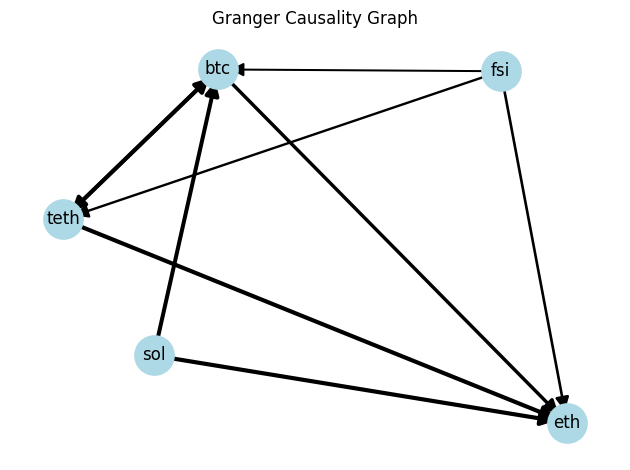

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Define node labels
node_labels = ['btc', 'eth', 'sol', 'teth', 'fsi']

# Create directed graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(node_labels)

# Add edges where granger_matrix[i, j] ≠ 0 (skip self-loops)
for i, src in enumerate(node_labels):
    for j, tgt in enumerate(node_labels):
        if i != j and granger_matrix[i, j] != 0:
            G.add_edge(src, tgt, weight=granger_matrix[i, j])

# Choose layout
pos = nx.spring_layout(G, seed=42)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue')

# Draw edges with width scaled by weight
edges = G.edges()
weights = [G[u][v]['weight'] * 3 for u, v in edges]  # scale weight for visibility
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, arrows=True, arrowstyle='-|>', arrowsize=20)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

# Final plot adjustments
plt.title("Granger Causality Graph")
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
#Target preparation
crypto_targets = []

input_window = 14
forecast_horizons = [1, 3, 6]

for i in range(len(crypto_matrix) - input_window - max(forecast_horizons)):
    price_t = crypto_matrix[i + input_window - 1]  # price at t+13
    price_t_horizons = crypto_matrix[i + input_window + np.array(forecast_horizons) - 1]  # t+14, t+16, t+19

    log_returns = np.log(price_t_horizons / price_t).reshape(4, -1)  # (4, 3)
    crypto_targets.append(log_returns)

# Final target array: (num_samples, 4, 3)
final_targets = np.stack(crypto_targets)




In [ ]:
#Data Preparation
from torch.utils.data import Dataset

class CryptoDataset(Dataset):
    def __init__(self, data, normalized_targets, input_window=14):
        """
        data: pandas DataFrame (combined_features) → shape (total_len, 5)
        normalized_targets: numpy array, shape (num_samples, 4, 3)
        """
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.targets = torch.tensor(normalized_targets, dtype=torch.float32)
        self.input_window = input_window
        self.samples = self._generate_samples()

    def _generate_samples(self):
        samples = []
        num_samples = len(self.targets)

        for t in range(num_samples):
            # Input includes all 5 nodes (crypto + FSI)
            x = self.data[t:t + self.input_window].T.unsqueeze(1)  # (5, 1, 14)
            y = self.targets[t]  # Only crypto targets → shape (4, 3)
            samples.append((x, y))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]




In [ ]:
from torch.utils.data import DataLoader

dataset = CryptoDataset(combined_features_processed, normalized_targets=final_targets)  # ← pass raw log-return targets

# --- DataLoader for batching ---
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
#Model class Definition
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class STGNN(nn.Module):
    def __init__(self, num_nodes=5, in_channels=1, hidden_dim=128, out_dim=1):
        """
        num_nodes: total nodes (cryptos + FSI → 5)
        in_channels: input channels (we keep it as 1)
        hidden_dim: hidden size
        out_dim: number of output horizons (set to 1 if training separate models per horizon)
        """
        super(STGNN, self).__init__()

        # First temporal block (1D CNN over time)
        self.temporal_block1 = nn.Conv1d(in_channels, hidden_dim, kernel_size=3, padding=1)

        # Graph convolution block (applied per timestep)
        self.spatial_block = GCNConv(hidden_dim, hidden_dim)

        # Second temporal block (1D CNN after spatial)
        self.temporal_block2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1)

        # MLP for final prediction
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, X, A):
        """
        X: shape (B, N=5, C=1, T=14)
        A: adjacency matrix (N, N)
        Returns: (B, 4, out_dim) → crypto nodes only
        """
        B, N, C, T = X.shape

        # Temporal Block 1
        X = X.view(B * N, C, T)             # (B*N, C, T)
        X = self.temporal_block1(X)         # → (B*N, hidden_dim, T)
        X = F.relu(X)

        X = X.view(B, N, -1, T)             # (B, N, hidden_dim, T)

        # Spatial Block (GCN per timestep)
        gcn_outputs = []
        edge_index = A.nonzero(as_tuple=False).T  # edge list once

        for t in range(T):
            x_t = X[:, :, :, t]                   # (B, N, hidden_dim) at t
            x_t = x_t.view(B * N, -1)            # (B*N, hidden_dim)
            out_t = self.spatial_block(x_t, edge_index)
            out_t = F.relu(out_t)
            gcn_outputs.append(out_t.view(B, N, -1))  # (B, N, hidden_dim)

        X = torch.stack(gcn_outputs, dim=-1)      # (B, N, hidden_dim, T)

        # Temporal Block 2
        X = X.view(B * N, -1, T)                 # (B*N, hidden_dim, T)
        X = self.temporal_block2(X)              # → (B*N, hidden_dim, T)
        X = F.relu(X)

        # Aggregate over time (mean pooling)
        X = X.mean(dim=-1)                       # (B*N, hidden_dim)

        # MLP Head
        X = X.view(B, N, -1)                     # (B, N, hidden_dim)
        X = self.mlp(X)                          # (B, N, out_dim)

        # Only return crypto nodes (exclude FSI)
        X_crypto = X[:, :4, :]                   # (B, 4, out_dim)

        return X_crypto


In [ ]:
#Training
import torch
import torch.nn as nn
import torch.optim as optim

# --- DEVICE SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- METRIC FUNCTIONS ---
def rmse(preds, targets):
    return torch.sqrt(torch.mean((preds - targets) ** 2, dim=0))

def mae(preds, targets):
    return torch.mean(torch.abs(preds - targets), dim=0)

def mape(preds, targets, eps=1e-8):
    return torch.mean(torch.abs((preds - targets) / (targets + eps)), dim=0) * 100

# --- MAIN HORIZON LOOP ---
horizons = [1, 3, 6]
num_epochs = 100

for selected_horizon in [0, 1, 2]:  # 0 → +1d, 1 → +3d, 2 → +6d
    print(f"\n=== Training model for horizon +{horizons[selected_horizon]} days ===")

    # --- MODEL DEFINITION ---
    model = STGNN(num_nodes=5, in_channels=1, hidden_dim=128, out_dim=1)
    model = model.to(device)
    A = A.to(device)

    # --- OPTIMIZER & SCHEDULER ---
    optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)
    criterion = nn.MSELoss()

    try:
        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0.0

            for batch_x, batch_y in dataloader:
                batch_x = batch_x.to(device)  # (B, N, 1, T)
                batch_y = batch_y[..., selected_horizon].to(device)  # (B, N)

                optimizer.zero_grad()
                predictions = model(batch_x, A).squeeze(-1)  # (B, N, 1) → (B, N)
                loss = criterion(predictions, batch_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            scheduler.step()
            avg_loss = epoch_loss / len(dataloader)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}, LR: {scheduler.get_last_lr()[0]:.6f}")

        # Save model for this horizon
        model_save_path = f"stgnn_model_horizon_{horizons[selected_horizon]}d.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"✅ Saved model: {model_save_path}")

        # --- Quick One-Batch Evaluation ---
        model.eval()
        with torch.no_grad():
            batch_x, batch_y = next(iter(dataloader))
            batch_x = batch_x.to(device)
            batch_y = batch_y[..., selected_horizon].to(device)  # Only selected horizon

            preds = model(batch_x, A).squeeze(-1)

            rmse_val = rmse(preds, batch_y)
            mae_val = mae(preds, batch_y)
            mape_val = mape(preds, batch_y)

            print(f"Quick Eval - RMSE: {rmse_val.mean():.4f}, MAE: {mae_val.mean():.4f}, MAPE: {mape_val.mean():.2f}%")

    except Exception as e:
        print(f"❌ Training stopped due to error: {e}")
        torch.save(model.state_dict(), f"stgnn_model_error_horizon_{horizons[selected_horizon]}d.pth")


Using device: cuda

=== Training model for horizon +1 days ===
Epoch 1/100, Loss: 0.006650, LR: 0.001000
Epoch 2/100, Loss: 0.006268, LR: 0.001000
Epoch 3/100, Loss: 0.006282, LR: 0.001000
Epoch 4/100, Loss: 0.006331, LR: 0.001000
Epoch 5/100, Loss: 0.006330, LR: 0.001000
Epoch 6/100, Loss: 0.006183, LR: 0.001000
Epoch 7/100, Loss: 0.006166, LR: 0.001000
Epoch 8/100, Loss: 0.006203, LR: 0.001000
Epoch 9/100, Loss: 0.006164, LR: 0.001000
Epoch 10/100, Loss: 0.006237, LR: 0.001000
Epoch 11/100, Loss: 0.006201, LR: 0.001000
Epoch 12/100, Loss: 0.006129, LR: 0.001000
Epoch 13/100, Loss: 0.006149, LR: 0.001000
Epoch 14/100, Loss: 0.006147, LR: 0.001000
Epoch 15/100, Loss: 0.006183, LR: 0.001000
Epoch 16/100, Loss: 0.006092, LR: 0.001000
Epoch 17/100, Loss: 0.006092, LR: 0.001000
Epoch 18/100, Loss: 0.006113, LR: 0.001000
Epoch 19/100, Loss: 0.006073, LR: 0.001000
Epoch 20/100, Loss: 0.006168, LR: 0.000700
Epoch 21/100, Loss: 0.006086, LR: 0.000700
Epoch 22/100, Loss: 0.006053, LR: 0.000700


In [ ]:

# To get the last 13 rows of the raw train data
#raw_train_data = np.concatenate((crypto_matrix, fsi_values), axis=1)
#raw_last_train_rows = raw_train_data.iloc[-13:].copy()

# Get last 13 rows of transforms/normalized training data
#last_train_rows = combined_features.iloc[-13:].copy()  # Shape: (13, 5)

In [ ]:
btc_df = pd.read_csv("/content/drive/MyDrive/Testdataset/BTC.csv")
eth_df = pd.read_csv("/content/drive/MyDrive/Testdataset/ETH.csv")
teth_df = pd.read_csv("/content/drive/MyDrive/Testdataset/USDT.csv")
sol_df = pd.read_csv("/content/drive/MyDrive/Testdataset/SOL.csv")
fsi_df = pd.read_csv("/content/drive/MyDrive/Testdataset/FSI.csv")

# Using the minimum number of rows
min_rows = min(btc_df.shape[0], eth_df.shape[0], sol_df.shape[0], teth_df.shape[0])

# Trimming each dataframe to have the same number of rows
btc_df = btc_df.iloc[:min_rows, :]
eth_df = eth_df.iloc[:min_rows, :]
sol_df = sol_df.iloc[:min_rows, :]
teth_df = teth_df.iloc[:min_rows, :]

#COnvert to datetime
fsi_df["Date"] = pd.to_datetime(fsi_df["Date"])
btc_df["Date"] = pd.to_datetime(btc_df["Date"])
eth_df["Date"] = pd.to_datetime(eth_df["Date"])
sol_df["Date"] = pd.to_datetime(sol_df["Date"])
teth_df["Date"] = pd.to_datetime(teth_df["Date"])

# Set date as index to allow change the order
btc_df.set_index("Date", inplace=True)
eth_df.set_index("Date", inplace=True)
sol_df.set_index("Date", inplace=True)
teth_df.set_index("Date", inplace=True)

# Change the order of the dataframes
btc_df = btc_df.sort_index(ascending=True)
eth_df = eth_df.sort_index(ascending=True)
sol_df = sol_df.sort_index(ascending=True)
teth_df = teth_df.sort_index(ascending=True)

In [ ]:
cryptos = [btc_df["Price"], eth_df["Price"], sol_df["Price"], teth_df["Price"]]
test_crypto_matrix = np.stack(cryptos, axis=1)

# Add FSI as a feature
fsi = fsi_df.set_index("Date").reindex(btc_df.index, method="ffill").reset_index()

test_fsi_values = fsi["OFR FSI"].values.reshape(-1, 1)

# Convert string columns to float
for i in range(test_crypto_matrix.shape[1]):
    # Check if the first element in the column is a string
    if isinstance(test_crypto_matrix[0, i], str):
        # Convert the entire column to floats, handling commas
        test_crypto_matrix[:, i] = [float(value.replace(',', '')) for value in test_crypto_matrix[:, i]]

# Ensure the array is now numeric
test_crypto_matrix = test_crypto_matrix.astype(float)

# Convert to log returns
test_log_returns = np.log(test_crypto_matrix[1:] / test_crypto_matrix[:-1])

# Convert to DataFrame for better visualization
test_log_returns_df = pd.DataFrame(test_log_returns, columns=["btc", "eth", "sol", "teth"])

# Calculate the first difference
test_fsi_diff = np.diff(test_fsi_values, axis=0)

# Convert to DataFrame for better visualization (optional)
fsi_diff_df = pd.DataFrame(test_fsi_diff, columns=["FSI First Difference"])


In [ ]:
fsi_diff_df.describe()

,FSI First Difference
count,31.000000
mean,0.002484
std,0.300645
min,-1.129000
25%,-0.079000
50%,0.000000
75%,0.039500
max,1.036000


In [ ]:
test_fsi_diff.shape

(31, 1)

In [ ]:
# Step 1: Normalize only FSI diff (fit scaler on training FSI diffs)
fsi_scaler = StandardScaler()
fsi_scaler.fit(fsi_diff.reshape(-1, 1))

test_fsi_diff_normalized = fsi_scaler.transform(test_fsi_diff)

# Step 2: Combine raw test log returns + normalized test FSI diff
combined_test_features = pd.concat(
    [test_log_returns_df, pd.DataFrame(test_fsi_diff_normalized, columns=["FSI_Diff"])],
    axis=1
)

# Step 3: Get last 13 rows of normalized training data
last_train_rows = combined_features_processed.iloc[-13:].copy()

# Step 4: Combine for evaluation
combined_eval_data = pd.concat(
    [last_train_rows, combined_test_features],
    ignore_index=True
)

print(f"Combined eval data shape: {combined_eval_data.shape}")  # Should match (13 + 32 = 45, 5)


Combined eval data shape: (44, 5)


In [ ]:
combined_test_features.shape

(31, 5)

In [ ]:
# To get the last 13 rows of the raw train data
raw_train_data = np.concatenate((crypto_matrix, fsi_values), axis=1)
# Extract the last 13 rows using NumPy indexing
raw_last_train_rows = raw_train_data[-13:].copy()    #shape: (13:5)

# Get raw test data set and join to the 13 rows of raw train data
raw_test_data = np.concatenate((test_crypto_matrix, test_fsi_values), axis=1)
# Concatenate with test data
combined_raw_eval_data = np.concatenate([raw_last_train_rows, raw_test_data])  # Shape: (45, 5)


In [ ]:
horizons = [1, 3, 6]
num_windows = 12  # fixed
window_size=14
# Initialize storage for each horizon
all_rmse = []
all_mae = []
all_mape = []
for horizon_idx, horizon in enumerate(horizons):
    print(f"\n=== Evaluating Model for Horizon: +{horizon} Days ===")

    all_preds = []
    all_true = []


    for i in range(num_windows):
        # --- Prepare Input Window ---
        window_data = combined_eval_data.iloc[i:i + window_size].values  # (14, 5)
        window_tensor = torch.tensor(window_data.T, dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)  # (1, 5, 1, 14)

        # --- Previous crypto price ---
        prev_crypto_price = combined_raw_eval_data[i + window_size - 1, :4]  # (4,)
        prev_crypto_price_tensor = torch.tensor(prev_crypto_price, dtype=torch.float32)

        # --- Ground Truth (Crypto Only) ---
        future_index = i + window_size + horizon - 1
        test_index = future_index - 13  # adjust for test set alignment

        if test_index >= len(test_crypto_matrix):
            print(f"Skipping window {i}: test index {test_index} out of bounds")
            continue

        future_crypto = test_crypto_matrix[test_index]  # (4,)
        true_crypto_tensor = torch.tensor(future_crypto, dtype=torch.float32)

        # --- Load and use the corresponding model ---
        model_path = f"stgnn_model_horizon_{horizons[horizon_idx]}d.pth"
        model.load_state_dict(torch.load(model_path))
        model.eval()

        with torch.no_grad():
            preds = model(window_tensor, A)  # (1, 5, 1)
        preds_crypto = preds[:, :4, 0].squeeze(0).cpu()  # (4,)

        # --- Recover predicted prices ---
        recovered_crypto_pred = prev_crypto_price_tensor * torch.exp(preds_crypto)  # (4,)

        all_preds.append(recovered_crypto_pred)
        all_true.append(true_crypto_tensor)

    # Stack predictions and true values
    all_preds_tensor = torch.stack(all_preds)  # (num_windows, 4)
    all_true_tensor = torch.stack(all_true)    # (num_windows, 4)

    # --- Compute Metrics ---
    rmse = torch.sqrt(torch.mean((all_preds_tensor - all_true_tensor) ** 2, dim=0))
    mae = torch.mean(torch.abs(all_preds_tensor - all_true_tensor), dim=0)
    mape = torch.mean(torch.abs((all_preds_tensor - all_true_tensor) / (all_true_tensor + 1e-8)), dim=0) * 100

    print(f"RMSE per crypto: {rmse}")
    print(f"MAE per crypto:  {mae}")
    print(f"MAPE per crypto: {mape}")

    all_rmse.append(rmse)
    all_mae.append(mae)
    all_mape.append(mape)



=== Evaluating Model for Horizon: +1 Days ===
RMSE per crypto: tensor([1.4028e+03, 5.9407e+01, 5.6983e+00, 1.8556e-02])
MAE per crypto:  tensor([1.2263e+03, 4.6752e+01, 4.9763e+00, 1.6661e-02])
MAPE per crypto: tensor([1.9638, 1.9000, 3.4045, 1.6663])

=== Evaluating Model for Horizon: +3 Days ===
RMSE per crypto: tensor([2.0309e+03, 7.1016e+01, 5.8499e+00, 2.5592e-02])
MAE per crypto:  tensor([1.6787e+03, 5.9473e+01, 4.9114e+00, 2.4180e-02])
MAPE per crypto: tensor([2.6715, 2.4109, 3.3293, 2.4187])

=== Evaluating Model for Horizon: +6 Days ===
RMSE per crypto: tensor([3.9184e+03, 1.3330e+02, 1.1896e+01, 4.6460e-03])
MAE per crypto:  tensor([3.1351e+03, 1.1035e+02, 1.0395e+01, 3.9701e-03])
MAPE per crypto: tensor([4.7190, 4.2767, 6.8227, 0.3971])


In [ ]:

# Step 2: (After horizon loop) Stack into (3, 4) tensors
rmse_tensor = torch.stack(all_rmse)  # shape: (3, 4)
mae_tensor = torch.stack(all_mae)    # shape: (3, 4)
mape_tensor = torch.stack(all_mape)  # shape: (3, 4)

# Step 3: Get price ranges from training data
node_names = ["btc", "eth", "sol", "teth"]
price_ranges = [crypto_matrix[:, i].max() - crypto_matrix[:, i].min() for i in range(4)]
price_range_tensor = torch.tensor(price_ranges)

# Step 4: Compute normalized and averaged metrics
avg_metrics = {"horizon": [], "avg_norm_rmse": [], "avg_norm_mae": [], "avg_mape": []}
horizons = [1, 3, 6]

for i, h in enumerate(horizons):
    norm_rmse = rmse_tensor[i] / price_range_tensor
    norm_mae = mae_tensor[i] / price_range_tensor
    avg_norm_rmse = norm_rmse.mean().item()
    avg_norm_mae = norm_mae.mean().item()
    avg_mape = mape_tensor[i].mean().item()

    avg_metrics["horizon"].append(f"+{h}d")
    avg_metrics["avg_norm_rmse"].append(avg_norm_rmse)
    avg_metrics["avg_norm_mae"].append(avg_norm_mae)
    avg_metrics["avg_mape"].append(avg_mape)

# Step 5: Display as DataFrame
df_avg = pd.DataFrame(avg_metrics)
print(df_avg)



  horizon  avg_norm_rmse  avg_norm_mae  avg_mape
0     +1d       0.469066      0.420553  2.233656
1     +3d       0.644768      0.607238  2.707583
2     +6d       0.148041      0.125699  4.053913


In [ ]:

# Step 1: Define horizon labels
horizons = [1, 3, 6]
horizon_labels = [f"+{h} Day" for h in horizons]

# Step 2: Recalculate normalized metrics and averages
node_names = ["btc", "eth", "sol", "teth"]

# Get price ranges from training data
price_ranges = {}
for i, name in enumerate(node_names):
    min_val = crypto_matrix[:, i].min()
    max_val = crypto_matrix[:, i].max()
    price_ranges[name] = max_val - min_val

# Step 3: Prepare rows for the DataFrame
rows = []
for i, h in enumerate(horizons):
    rmse = all_rmse[i]
    mae = all_mae[i]
    mape = all_mape[i]

    norm_rmse = torch.tensor([rmse[j].item() / price_ranges[node_names[j]] for j in range(4)])
    norm_mae = torch.tensor([mae[j].item() / price_ranges[node_names[j]] for j in range(4)])

    avg_rmse = norm_rmse.mean().item()
    avg_mae = norm_mae.mean().item()
    avg_mape = mape.mean().item()

    rows.append({
        "Horizon": f"+{h} Day",
        "Avg Normalized RMSE": avg_rmse,
        "Avg Normalized MAE": avg_mae,
        "Avg MAPE": avg_mape
    })

# Step 4: Create DataFrame and Save
df_results = pd.DataFrame(rows)
df_results.to_csv("/content/drive/MyDrive/Results/Grangernormeval.csv", index=False)
print("✅ Metrics saved to: /content/drive/MyDrive/Results/Grangernormeval.csv")


✅ Metrics saved to: /content/drive/MyDrive/Results/Grangernormeval.csv


In [ ]:
import torch

# === Setup ===
window_size = 14
num_windows = 32  # Full test range
horizons = [1, 3, 6]
model_paths = {
    1: "stgnn_model_horizon_1d.pth",
    3: "stgnn_model_horizon_3d.pth",
    6: "stgnn_model_horizon_6d.pth"
}
preds_horizon = {1: [], 3: [], 6: []}
all_true = []

# Loop over each time step in the test range
for i in range(num_windows):
    window_data = combined_eval_data.iloc[i:i + window_size].values  # (14, 5)
    window_tensor = torch.tensor(window_data.T, dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)  # (1, 5, 1, 14)

    # Ground truth (actual price at day i+window_size)
    true_crypto = test_crypto_matrix[i]  # shape (4,)
    all_true.append(torch.tensor(true_crypto, dtype=torch.float32))

    for horizon in horizons:
        # Skip if not enough future data
        if i + horizon > len(test_crypto_matrix) - 1:
            preds_horizon[horizon].append(torch.tensor([float("nan")] * 4))  # or skip
            continue

        # Load model
        model = STGNN(num_nodes=5, in_channels=1, hidden_dim=128, out_dim=1).to(device)
        model.load_state_dict(torch.load(model_paths[horizon]))
        model.eval()

        with torch.no_grad():
            preds = model(window_tensor, A)[:, :4, 0].squeeze(0).cpu()  # (4,)
            prev_price = combined_raw_eval_data[i + window_size - 1, :4]  # (4,)
            prev_price_tensor = torch.tensor(prev_price, dtype=torch.float32)

            # Recover price from log return
            recovered = prev_price_tensor * torch.exp(preds)
            preds_horizon[horizon].append(recovered)

# Stack predictions and true values
all_true_tensor = torch.stack(all_true)                          # shape: (32, 4)
preds_h1_tensor = torch.stack(preds_horizon[1])[:32]             # shape: (32, 4)
preds_h3_tensor = torch.stack(preds_horizon[3])[:32]
preds_h6_tensor = torch.stack(preds_horizon[6])[:32]

print("✅ Tensors ready:")
print("  all_true_tensor :", all_true_tensor.shape)
print("  preds_h1_tensor :", preds_h1_tensor.shape)
print("  preds_h3_tensor :", preds_h3_tensor.shape)
print("  preds_h6_tensor :", preds_h6_tensor.shape)


✅ Tensors ready:
  all_true_tensor : torch.Size([32, 4])
  preds_h1_tensor : torch.Size([32, 4])
  preds_h3_tensor : torch.Size([32, 4])
  preds_h6_tensor : torch.Size([32, 4])


In [ ]:
from datetime import datetime, timedelta
import pandas as pd

crypto_names = ["btc", "eth", "sol", "teth"]
start_date = datetime.strptime("2024-10-02", "%Y-%m-%d")  # first test date
aligned_records = []

# Target alignment range (from day 6 to 31 = index 6 to 31) → 26 days
for d in range(6, 22):
    current_date = start_date + timedelta(days=d)

    actual = all_true_tensor[d]                # ground truth for day D
    pred_1 = preds_h1_tensor[d - 1]            # predicted at D−1 for D
    pred_3 = preds_h3_tensor[d - 3]            # predicted at D−3 for D
    pred_6 = preds_h6_tensor[d - 6]            # predicted at D−6 for D

    for i, crypto in enumerate(crypto_names):
        aligned_records.append({
            "date": current_date.strftime("%Y-%m-%d"),
            "crypto": crypto,
            "actual": actual[i].item(),
            "pred_T+1": pred_1[i].item(),
            "pred_T+3": pred_3[i].item(),
            "pred_T+6": pred_6[i].item()
        })

# Convert to DataFrame
df_aligned = pd.DataFrame(aligned_records)

# Preview
print(df_aligned.head())


         date crypto        actual      pred_T+1      pred_T+3      pred_T+6
0  2024-10-08    btc  66081.703125  61898.835938  63744.421875  60260.035156
1  2024-10-08    eth   2630.540039   2410.393066   2479.979736   2353.724609
2  2024-10-08    sol    157.535995    139.347610    144.743317    135.697372
3  2024-10-08   teth      0.999700      0.989082      1.022041      1.001753
4  2024-10-09    btc  67077.500000  62448.453125  64762.277344  60761.316406


In [ ]:
import os

# Create directory on your Drive (if not already)
save_dir = "/content/drive/MyDrive/Results/Granger"
os.makedirs(save_dir, exist_ok=True)

# Save one CSV per crypto
for crypto in crypto_names:
    df_crypto = df_aligned[df_aligned["crypto"] == crypto]
    save_path = os.path.join(save_dir, f"{crypto}_linechart_data.csv")
    df_crypto.to_csv(save_path, index=False)
    print(f"✅ Saved: {save_path}")


✅ Saved: /content/drive/MyDrive/Results/Granger/btc_linechart_data.csv
✅ Saved: /content/drive/MyDrive/Results/Granger/eth_linechart_data.csv
✅ Saved: /content/drive/MyDrive/Results/Granger/sol_linechart_data.csv
✅ Saved: /content/drive/MyDrive/Results/Granger/teth_linechart_data.csv


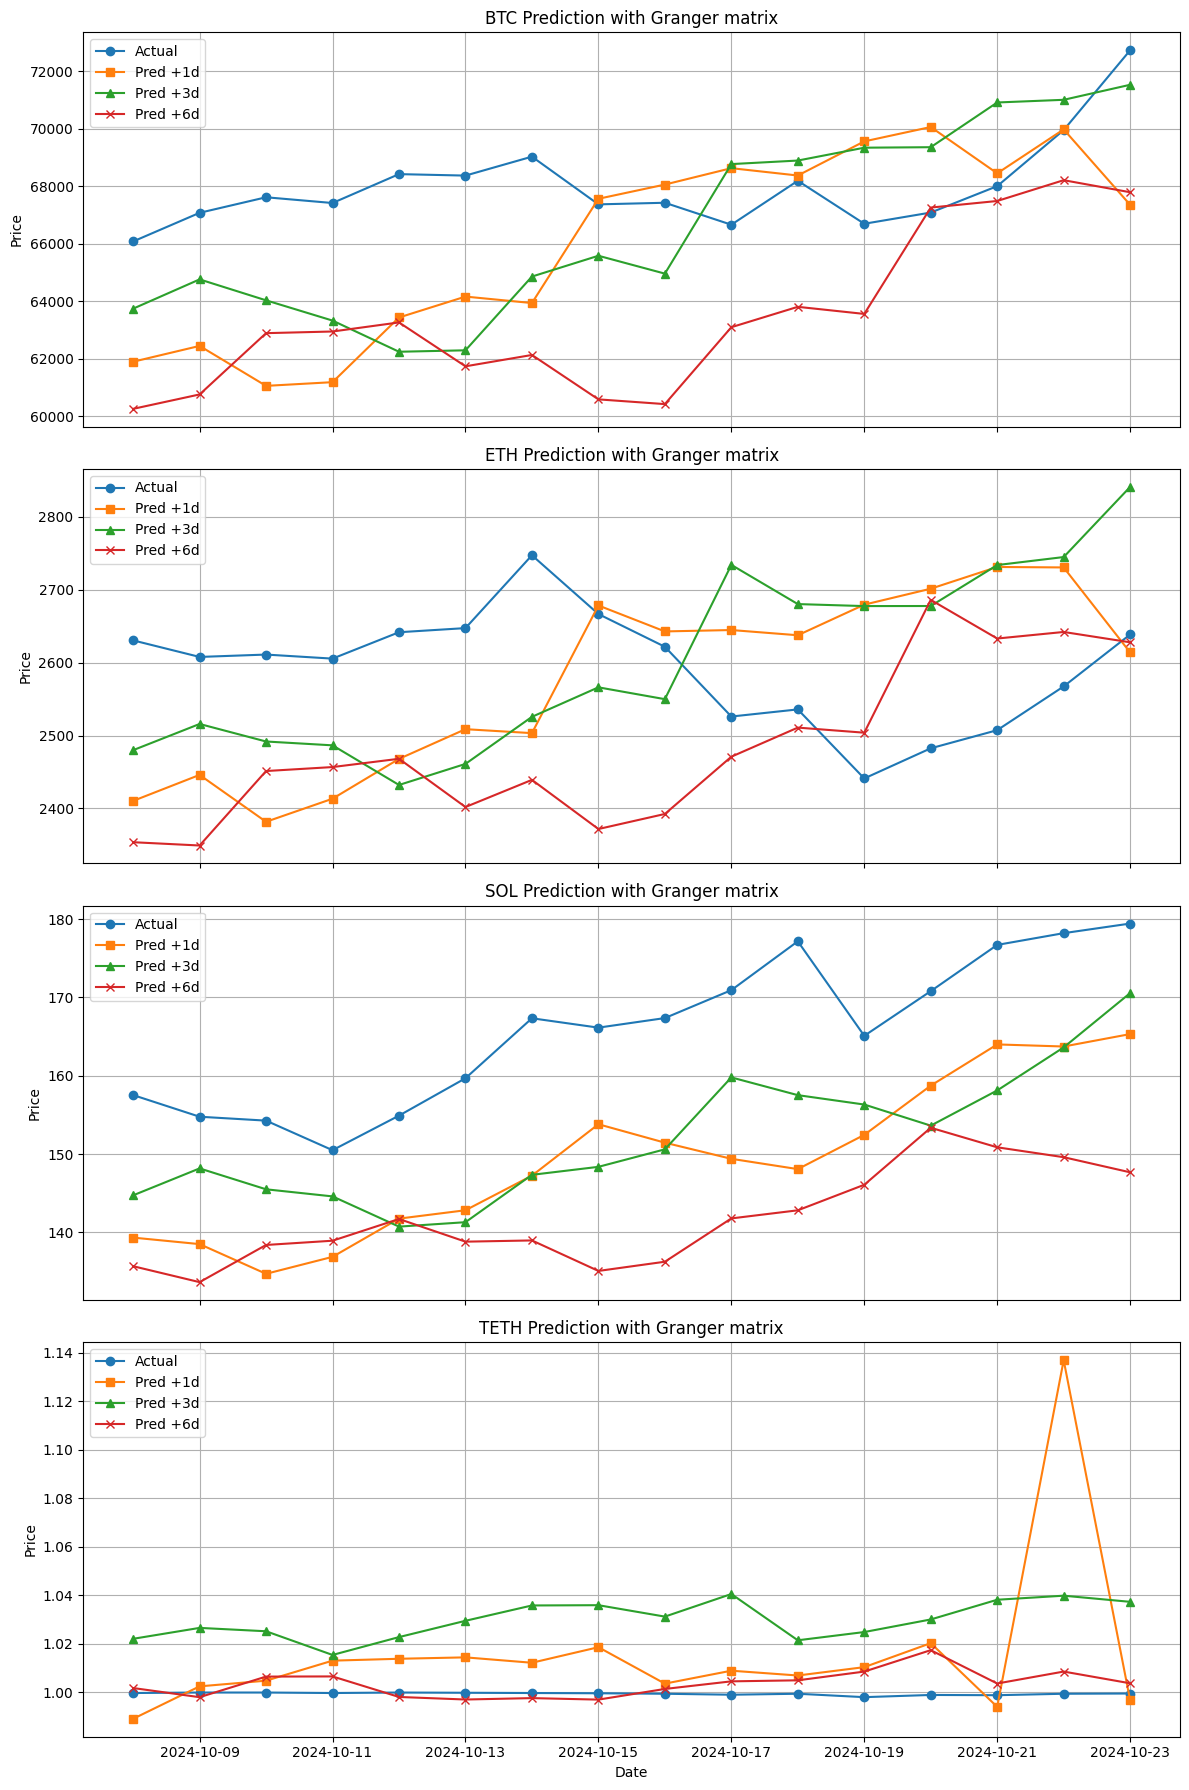

In [ ]:

# Define crypto names and path template
cryptos = ['btc', 'eth', 'sol', 'teth']
path_template = "/content/drive/MyDrive/Results/Granger/{}_linechart_data.csv"

# Set up a vertical layout of 4 subplots (one for each crypto)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 18), sharex=True)

#fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(11.7, 8.3), sharex=True)  To make it fit in A4 paper


for i, crypto in enumerate(cryptos):
    # Load CSV
    df = pd.read_csv(path_template.format(crypto))
    df['date'] = pd.to_datetime(df['date'])

    # Plot actual and predicted values
    axes[i].plot(df['date'], df['actual'], label='Actual', marker='o')
    axes[i].plot(df['date'], df['pred_T+1'], label='Pred +1d', marker='s')
    axes[i].plot(df['date'], df['pred_T+3'], label='Pred +3d', marker='^')
    axes[i].plot(df['date'], df['pred_T+6'], label='Pred +6d', marker='x')

    axes[i].set_title(f"{crypto.upper()} Prediction with Granger matrix")
    axes[i].set_ylabel("Price")
    axes[i].grid(True)
    axes[i].legend()

# Label shared x-axis
axes[-1].set_xlabel("Date")

# Improve spacing
plt.tight_layout()
plt.show()
#plt.savefig("/content/drive/MyDrive/Results/Granger/crypto_linecharts_A4.png", dpi=300, bbox_inches='tight') To save as an image to embed in my repot





In [ ]:
#TO RELOAD AND EVALUATE THE MODEL
import torch

# --- Setup ---
horizons = [1, 3, 6]
window_size = 14
num_windows = 24  # fixed as you set

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# --- Load all models into memory ---
horizon_models = {}
for horizon in horizons:
    model = STGNN(num_nodes=5, in_channels=1, hidden_dim=128, out_dim=1)
    model_path = f"stgnn_model_horizon_{horizon}d.pth"
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    horizon_models[horizon] = model
    print(f"✅ Loaded model for horizon +{horizon}d")

# --- Evaluation Loop ---
for horizon in horizons:
    print(f"\n=== Evaluating Model for Horizon: +{horizon} Days ===")

    model = horizon_models[horizon]

    all_preds = []
    all_true = []

    for i in range(num_windows):
        window_data = combined_eval_data.iloc[i:i + window_size].values  # (14, 5)
        window_tensor = torch.tensor(window_data.T, dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)

        prev_crypto_price = combined_raw_eval_data[i + window_size - 1, :4]  # (4,)
        prev_crypto_price_tensor = torch.tensor(prev_crypto_price, dtype=torch.float32)

        future_index = i + window_size + horizon - 1
        test_index = future_index - 13  # adjust for test set alignment

        if test_index >= len(test_crypto_matrix):
            print(f"⚠ Skipping window {i}: test index {test_index} out of bounds")
            continue

        future_crypto = test_crypto_matrix[test_index]  # (4,)
        true_crypto_tensor = torch.tensor(future_crypto, dtype=torch.float32)

        with torch.no_grad():
            preds = model(window_tensor, A)  # (1, 5, 1)
        preds_crypto = preds[:, :4, 0].squeeze(0).cpu()  # (4,)

        # Recover predicted prices
        recovered_crypto_pred = prev_crypto_price_tensor * torch.exp(preds_crypto)  # (4,)

        all_preds.append(recovered_crypto_pred)
        all_true.append(true_crypto_tensor)

    # Stack predictions and true values
    all_preds_tensor = torch.stack(all_preds)  # (num_windows, 4)
    all_true_tensor = torch.stack(all_true)    # (num_windows, 4)

    # Compute Metrics
    rmse = torch.sqrt(torch.mean((all_preds_tensor - all_true_tensor) ** 2, dim=0))
    mae = torch.mean(torch.abs(all_preds_tensor - all_true_tensor), dim=0)
    mape = torch.mean(torch.abs((all_preds_tensor - all_true_tensor) / (all_true_tensor + 1e-8)), dim=0) * 100

    print(f"✅ RMSE per crypto: {rmse}")
    print(f"✅ MAE per crypto:  {mae}")
    print(f"✅ MAPE per crypto: {mape}")




✅ Using device: cuda
✅ Loaded model for horizon +1d
✅ Loaded model for horizon +3d
✅ Loaded model for horizon +6d

=== Evaluating Model for Horizon: +1 Days ===
✅ RMSE per crypto: tensor([1.3376e+03, 6.0543e+01, 5.6941e+00, 3.2025e-02])
✅ MAE per crypto:  tensor([1.1485e+03, 5.0998e+01, 4.9981e+00, 1.8821e-02])
✅ MAPE per crypto: tensor([1.7735, 2.0210, 3.2196, 1.8828])

=== Evaluating Model for Horizon: +3 Days ===
✅ RMSE per crypto: tensor([2.3302e+03, 1.2555e+02, 6.4627e+00, 3.1349e-02])
✅ MAE per crypto:  tensor([1.9297e+03, 9.6188e+01, 5.4832e+00, 2.9785e-02])
✅ MAPE per crypto: tensor([2.9524, 3.8206, 3.4813, 2.9802])

=== Evaluating Model for Horizon: +6 Days ===
✅ RMSE per crypto: tensor([3.4569e+03, 1.6372e+02, 1.3071e+01, 1.1914e-02])
✅ MAE per crypto:  tensor([2.7633e+03, 1.3137e+02, 1.1363e+01, 9.0141e-03])
✅ MAPE per crypto: tensor([4.0821, 5.1524, 6.9981, 0.9021])
